### Load in Packages and Set Up Parameters

In [1]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()
# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [3]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Next, let’s install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI’s GPT and GPT-2.) We’ve selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don’t provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

In [4]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Load in Data

In [5]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
df_train_f = pd.read_csv("/kaggle/input/nort-bert-datasets/df_train_full_cleaned_pe.csv", encoding='utf_8_sig', low_memory=False)

# Import Test and Measure Balance

df_test_f = pd.read_csv("/kaggle/input/nort-bert-datasets/df_test_full_cleaned_pe.csv", encoding='utf_8_sig', low_memory=False)

# Import Validation and Measure Balance
# Import Flattened Data
df_valid_f = pd.read_csv("/kaggle/input/nort-bert-datasets/df_valid_full_cleaned_pe.csv", encoding='utf_8_sig', low_memory=False)

In [6]:
df_train_f.head(6)

,id,created_at,text,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.description,user.favourites_count,...,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True
0,'1.2781248368924918e+18',1.593564e+09,今天第一次上推特，看看世界,0.0,1.0,0,1.278122e+18,1.593563e+09,关心政治,0.0,...,1,0,1,0,1,1,1,1,1,0
1,'1.2797572269916938e+18',1.593953e+09,@ttingxiao 胡说八道,0.0,0.0,0,1.278122e+18,1.593563e+09,关心政治,0.0,...,1,0,1,0,1,1,1,1,1,0
2,'1.2818699475099935e+18',1.594457e+09,@VijayShankarKu1 @zlj517 Are you describing In...,0.0,0.0,0,1.278129e+18,1.593565e+09,中华人民共和国战略忽悠局北美司情资一处国家二级忽悠师,41.0,...,1,0,1,0,1,1,1,1,1,0
3,'1.2803084709364818e+18',1.594084e+09,"@auighur @realDonaldTrump just like Trump,with...",0.0,0.0,0,1.278129e+18,1.593565e+09,中华人民共和国战略忽悠局北美司情资一处国家二级忽悠师,41.0,...,1,0,1,0,1,1,1,1,1,0
4,'1.2818669493543813e+18',1.594456e+09,@USA_China_Talk 不依法治国，难道还以推治国？美国鼓吹的宪法精神又到哪了？,0.0,0.0,0,1.278129e+18,1.593565e+09,中华人民共和国战略忽悠局北美司情资一处国家二级忽悠师,41.0,...,1,0,1,0,1,1,1,1,1,0
5,'1.2811047401018737e+18',1.594274e+09,@grass9fish @SUMANsaurabh07 +1,0.0,0.0,0,1.278129e+18,1.593565e+09,中华人民共和国战略忽悠局北美司情资一处国家二级忽悠师,41.0,...,1,0,1,0,1,1,1,1,1,0


In [7]:
df_train_f['id'] = df_train_f['id'].apply(lambda x: x.replace("'", ''))
df_train_f['id'] = df_train_f['id'].astype('float')
df_valid_f['id'] = df_valid_f['id'].apply(lambda x: x.replace("'", ''))
df_valid_f['id'] = df_valid_f['id'].astype('float')
df_test_f['id'] = df_test_f['id'].apply(lambda x: x.replace("'", ''))
df_test_f['id'] = df_test_f['id'].astype('float')

In [8]:
print("full train:", len(df_train_f), "unique ids train:", len(df_train_f['id'].unique()), 
      "full valid:", len(df_valid_f), "unique ids valid:", len(df_valid_f['id'].unique()), 
      "full test:", len(df_test_f), "unique ids test:", len(df_test_f['id'].unique()))

#print("Train:", len(sentences_train), "Valid:", len(sentences_valid), "Test", len(sentences_test))

full train: 81286 unique ids train: 81286 full valid: 27835 unique ids valid: 27835 full test: 20518 unique ids test: 20518


In [9]:
df_train = df_train_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)
df_valid = df_valid_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)
df_test = df_test_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)

In [10]:
# FOR TESING OUT CODE PURPOSE ONLY. REMOVE ONCE ALL IS WORKING. 
#df_train = df_train[:2000]
#df_valid = df_valid[:2000]
#df_test = df_test[:2000]

In [11]:
df_train.head()

,id,created_at,text,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,...,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True
0,1.278125e+18,1.593564e+09,今天第一次上推特，看看世界,0.0,1.0,0,1.278122e+18,1.593563e+09,0.0,6.0,...,1,0,1,0,1,1,1,1,1,0
1,1.279757e+18,1.593953e+09,@ttingxiao 胡说八道,0.0,0.0,0,1.278122e+18,1.593563e+09,0.0,2.0,...,1,0,1,0,1,1,1,1,1,0
2,1.281870e+18,1.594457e+09,@VijayShankarKu1 @zlj517 Are you describing In...,0.0,0.0,0,1.278129e+18,1.593565e+09,41.0,1.0,...,1,0,1,0,1,1,1,1,1,0
3,1.280308e+18,1.594084e+09,"@auighur @realDonaldTrump just like Trump,with...",0.0,0.0,0,1.278129e+18,1.593565e+09,41.0,1.0,...,1,0,1,0,1,1,1,1,1,0
4,1.281867e+18,1.594456e+09,@USA_China_Talk 不依法治国，难道还以推治国？美国鼓吹的宪法精神又到哪了？,0.0,0.0,0,1.278129e+18,1.593565e+09,41.0,1.0,...,1,0,1,0,1,1,1,1,1,0


Concatanate all texts to get one doc j per each user i

In [12]:
df_train = df_train.groupby(['user.id', 'suspended'])['text'].apply(lambda x: ' '.join(x)).reset_index()
df_train.head()

,user.id,suspended,text
0,1.278122e+18,0,今天第一次上推特，看看世界 @ttingxiao 胡说八道
1,1.278129e+18,0,@VijayShankarKu1 @zlj517 Are you describing In...
2,1.278132e+18,0,https://t.co/x6PEeWW48S #3qex https://t.co/eez...
3,1.278138e+18,0,@getput @zhanglifan 为什么西方所谓的双标的平等，自由就是对的？这就是典型...
4,1.278150e+18,1,WaxPar DC18RC 互換充電器 対応 マキタ 14.4V 18V リチウムイオンバッ...


In [13]:
df_valid = df_valid.groupby(['user.id', 'suspended'])['text'].apply(lambda x: ' '.join(x)).reset_index()
df_valid.head()

,user.id,suspended,text
0,1.278120e+18,1,@RFS_China 窝扪终锅震的是胎🍐害🌶 @SunZiyang2002 @kairun_...
1,1.278131e+18,0,@mian050715 @91porm 🤓
2,1.278136e+18,0,https://t.co/2tSmlYkG4v
3,1.278143e+18,0,@Kana_Momonogi I can't wait to Japan to have a...
4,1.278154e+18,0,@SpokespersonCHN 華姐辛苦了！明天國慶🇨🇳放假好好休息吧 @HuXijin_...


In [14]:
df_test = df_test.groupby(['user.id', 'suspended'])['text'].apply(lambda x: ' '.join(x)).reset_index()
df_test.head()

,user.id,suspended,text
0,1.278130e+18,0,@ImranKhanPTI me mazor adme ho
1,1.278145e+18,1,join amazon
2,1.278155e+18,0,@joshuawongcf jail is well prepared for you @c...
3,1.278156e+18,0,#SindhIsNotColonyIK Our message is clear that ...
4,1.278181e+18,0,Sentences have power.


### Split out text

In [15]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [16]:
df_train['text_split'] = df_train['text'].apply(get_split)
df_train.head()

,user.id,suspended,text,text_split
0,1.278122e+18,0,今天第一次上推特，看看世界 @ttingxiao 胡说八道,[今天第一次上推特，看看世界 @ttingxiao 胡说八道]
1,1.278129e+18,0,@VijayShankarKu1 @zlj517 Are you describing In...,[@VijayShankarKu1 @zlj517 Are you describing I...
2,1.278132e+18,0,https://t.co/x6PEeWW48S #3qex https://t.co/eez...,[https://t.co/x6PEeWW48S #3qex https://t.co/ee...
3,1.278138e+18,0,@getput @zhanglifan 为什么西方所谓的双标的平等，自由就是对的？这就是典型...,[@getput @zhanglifan 为什么西方所谓的双标的平等，自由就是对的？这就是典...
4,1.278150e+18,1,WaxPar DC18RC 互換充電器 対応 マキタ 14.4V 18V リチウムイオンバッ...,[WaxPar DC18RC 互換充電器 対応 マキタ 14.4V 18V リチウムイオンバ...


In [17]:
len(df_train)

1516

In [18]:
train_l = []
label_l = []
index_l =[]
userid_l = []
for idx,row in df_train.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        label_l.append(row['suspended'])
        index_l.append(idx)
        userid_l.append(row['user.id'])
len(train_l), len(label_l), len(index_l), len(userid_l)

(4771, 4771, 4771, 4771)

In [19]:
df_train = pd.DataFrame({'user.id':userid_l, 'text':train_l, 'suspended':label_l})
df_train.head()

,user.id,text,suspended
0,1.278122e+18,今天第一次上推特，看看世界 @ttingxiao 胡说八道,0
1,1.278129e+18,@VijayShankarKu1 @zlj517 Are you describing In...,0
2,1.278132e+18,https://t.co/x6PEeWW48S #3qex https://t.co/eez...,0
3,1.278132e+18,the founding 5 for getting this out to the wor...,0
4,1.278138e+18,@getput @zhanglifan 为什么西方所谓的双标的平等，自由就是对的？这就是典型...,0


In [20]:
df_train_2 = df_train.copy()
df_train_2['user.id'] = df_train_2['user.id'].astype('str')
df_train_2['user.id'] = df_train_2['user.id'].apply(lambda x: "'" + x + "'")
df_train_2['user.id'] = df_train_2['user.id'].astype('str')
df_train_2['user.id'] = df_train_2['user.id'].apply(lambda x: "'" + x + "'")

df_train_2.to_csv('df_train_2_overlap.csv', index=False, encoding = "utf_8_sig")

In [21]:
df_valid['text_split'] = df_valid['text'].apply(get_split)
df_valid.head()

,user.id,suspended,text,text_split
0,1.278120e+18,1,@RFS_China 窝扪终锅震的是胎🍐害🌶 @SunZiyang2002 @kairun_...,[@RFS_China 窝扪终锅震的是胎🍐害🌶 @SunZiyang2002 @kairun...
1,1.278131e+18,0,@mian050715 @91porm 🤓,[@mian050715 @91porm 🤓]
2,1.278136e+18,0,https://t.co/2tSmlYkG4v,[https://t.co/2tSmlYkG4v]
3,1.278143e+18,0,@Kana_Momonogi I can't wait to Japan to have a...,[@Kana_Momonogi I can't wait to Japan to have ...
4,1.278154e+18,0,@SpokespersonCHN 華姐辛苦了！明天國慶🇨🇳放假好好休息吧 @HuXijin_...,[@SpokespersonCHN 華姐辛苦了！明天國慶🇨🇳放假好好休息吧 @HuXijin...


In [22]:
val_l = []
val_label_l = []
val_index_l =[]
val_userid_l = []
for idx,row in df_valid.iterrows():
    for l in row['text_split']:
        val_l.append(l)
        val_label_l.append(row['suspended'])
        val_index_l.append(idx)
        val_userid_l.append(row['user.id'])
len(val_l), len(val_label_l), len(val_index_l),  len(val_userid_l)

(1957, 1957, 1957, 1957)

In [23]:
df_valid = pd.DataFrame({'user.id':val_userid_l, 'text':val_l, 'suspended':val_label_l})
df_valid.head()

,user.id,text,suspended
0,1.278120e+18,@RFS_China 窝扪终锅震的是胎🍐害🌶 @SunZiyang2002 @kairun_...,1
1,1.278120e+18,she has american citizenship @dw_chinese 你们之前不...,1
2,1.278120e+18,@ZhenTeMeBZDHanS 🍋🔒💧👉⑩什🐎❀呢？草履虫💧鞭毛蠕动🐎？ 曱由发野爹证一直...,1
3,1.278120e+18,@cortez_22_ @NXOnNetflix @CixinLiu For fuck's ...,1
4,1.278120e+18,@fenqudousha @Sovimath @ding_gang 你不会真的以为发这些颅内...,1


In [24]:
df_valid_2 = df_valid.copy()
df_valid_2['user.id'] = df_valid_2['user.id'].astype('str')
df_valid_2['user.id'] = df_valid_2['user.id'].apply(lambda x: "'" + x + "'")
df_valid_2['user.id'] = df_valid_2['user.id'].astype('str')
df_valid_2['user.id'] = df_valid_2['user.id'].apply(lambda x: "'" + x + "'")

df_valid_2.to_csv('df_valid_2_overlap.csv', index=False, encoding = "utf_8_sig")

In [25]:
df_test['text_split'] = df_test['text'].apply(get_split)
df_test.head()

,user.id,suspended,text,text_split
0,1.278130e+18,0,@ImranKhanPTI me mazor adme ho,[@ImranKhanPTI me mazor adme ho]
1,1.278145e+18,1,join amazon,[join amazon]
2,1.278155e+18,0,@joshuawongcf jail is well prepared for you @c...,[@joshuawongcf jail is well prepared for you @...
3,1.278156e+18,0,#SindhIsNotColonyIK Our message is clear that ...,[#SindhIsNotColonyIK Our message is clear that...
4,1.278181e+18,0,Sentences have power.,[Sentences have power.]


In [26]:
test_l = []
test_label_l = []
test_index_l =[]
test_userid_l = []
for idx,row in df_test.iterrows():
    for l in row['text_split']:
        test_l.append(l)
        test_label_l.append(row['suspended'])
        test_index_l.append(idx)
        test_userid_l.append(row['user.id'])
len(test_l), len(test_label_l), len(test_index_l), len(test_userid_l) 

(1306, 1306, 1306, 1306)

In [27]:
df_test = pd.DataFrame({'user.id':test_userid_l,'text':test_l, 'suspended':test_label_l})
df_test.head()

,user.id,text,suspended
0,1.278130e+18,@ImranKhanPTI me mazor adme ho,0
1,1.278145e+18,join amazon,1
2,1.278155e+18,@joshuawongcf jail is well prepared for you @c...,0
3,1.278156e+18,#SindhIsNotColonyIK Our message is clear that ...,0
4,1.278181e+18,Sentences have power.,0


In [28]:
df_test_2 = df_test.copy()
df_test_2['user.id'] = df_test_2['user.id'].astype('str')
df_test_2['user.id'] = df_test_2['user.id'].apply(lambda x: "'" + x + "'")
df_test_2['user.id'] = df_test_2['user.id'].astype('str')
df_test_2['user.id'] = df_test_2['user.id'].apply(lambda x: "'" + x + "'")

df_test_2.to_csv('df_test_2_overlap.csv', index=False, encoding = "utf_8_sig")

As you can see in this way we ended with a column (text_split) which every row has a list of string of around 200 word length.


In [29]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from numba import cuda 
import gc

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### Load in Model and Tokenizer

In [30]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-multilingual-cased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#model = model_class.from_pretrained(pretrained_weights)

In [31]:
gc.collect()
torch.cuda.empty_cache()

In [32]:
# Get the lists of sentences and their labels.
sentences_train = df_train.text.values
train_labels = df_train.suspended.values
ids_train = df_train.index.values

sentences_valid = df_valid.text.values
validation_labels = df_valid.suspended.values
ids_validation = df_valid.index.values

sentences_test = df_test.text.values
test_labels = df_test.suspended.values
ids_test = df_test.index.values

In [33]:
print("Train:", len(sentences_train), "Valid:", len(sentences_valid), "Test", len(sentences_test))

Train: 4771 Valid: 1957 Test 1306


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT–the below cell will download this for us.

In [34]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

Loading BERT tokenizer...


The tokenizer.encode function combines multiple steps for us:
- Split the sentence into tokens.
- Add the special [CLS] and [SEP] tokens.
- Map the tokens to their IDs.

Oddly, this function can perform truncating for us, but doesn’t handle padding.

### Prep Data for Model

In [35]:
def sent_to_ids(sentences): 
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    # For every sentence...
    for sent in sentences:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(
            sent,                      # Sentence to encode.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            # This function also supports truncation and conversion
            # to pytorch tensors, but we need to do padding, so we
            # can't use these features :( .
            #max_length = 128,          # Truncate all sentences.
            #return_tensors = 'pt',     # Return pytorch tensors.
        )
        # Add the encoded sentence to the list.
        input_ids.append(encoded_sent)
        # Pad and truncate our sequences so that they all have the same length
    input_ids = pad_sequences(input_ids, maxlen=120, dtype="long", 
                            value=0, truncating="post", padding="post")
    return input_ids

In [36]:
train_inputs = sent_to_ids(sentences_train)

Token indices sequence length is longer than the specified maximum sequence length for this model (1201 > 512). Running this sequence through the model will result in indexing errors


In [37]:
validation_inputs = sent_to_ids(sentences_valid)

In [38]:
test_inputs = sent_to_ids(sentences_test)

In [39]:
print("Train:", len(train_inputs), "Valid:", len(validation_inputs), "Test", len(test_inputs))

Train: 4771 Valid: 1957 Test 1306


In [40]:
def get_attn_msks(input_ids):
  # Create attention masks
    attention_masks = []
  # For each sentence...
    for sent in input_ids:
        # Create the attention mask.
        #   - If a token ID is 0, then it's padding, set the mask to 0.
        #   - If a token ID is > 0, then it's a real token, set the mask to 1.
        att_mask = [int(token_id > 0) for token_id in sent]
      
        # Store the attention mask for this sentence.
        attention_masks.append(att_mask)
    return attention_masks

In [41]:
train_masks = get_attn_msks(train_inputs)

In [42]:
validation_masks = get_attn_msks(validation_inputs)

In [43]:
test_masks = get_attn_msks(test_inputs)

Converting to PyTorch Data Types

Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [44]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

train_ids = torch.tensor(ids_train)
valid_ids = torch.tensor(ids_validation)

In [45]:
print("Train:", len(train_inputs), "Valid:", len(validation_inputs), "Test", len(test_inputs))

Train: 4771 Valid: 1957 Test 1306


We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [46]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.
batch_size = 16 # try 32, and then move down to 16 and 8. 
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_ids)
train_sampler = RandomSampler(train_data) # CHANGE TO SEQUENTIAL (TRAIN_SEQUENTIAL_SAMPLER - BUT DO SEQUENTIALLY FOR HIDDEN STATES)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, valid_ids)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our training set for the embedding extraction.
train_sampler_sequential = SequentialSampler(train_data) # CHANGE TO SEQUENTIAL (TRAIN_SEQUENTIAL_SAMPLER - BUT DO SEQUENTIALLY FOR HIDDEN STATES)
train_dataloader_sequential = DataLoader(train_data, sampler=train_sampler_sequential, batch_size=batch_size)

Now that our input data is properly formatted, it’s time to fine tune the BERT model.

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We’ll be using Bert Classification Model.This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.


In [47]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In the below cell we can check the names and dimensions of the weights for:The embedding layer,The first of the twelve transformers & The output layer.

In [48]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, we'll use the following values:

- Batch size: 16, 32 (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5 (We’ll use 2e-5).
- Number of epochs: 2, 3, 4 (We’ll use 4).

The epsilon parameter eps = 1e-8 is “a very small number to prevent any division by zero in the implementation”

https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1

In [49]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
# Cross entropy is used as the loss by default
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 2
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

4.3. Training Loop
Below is our training loop. There’s a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:

- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass.
- In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Define a helper function for calculating accuracy.

In [50]:
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.

In [51]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Train Model

In [52]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
loss_values_valid = []
#embeddings_tr, embeddings_vl = [], []
train_predictions, valid_predictions = [], []
train_true_labels, valid_true_labels = [], []
# Store the hidden states for embedding extraction

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs_a = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs_a[0]
        logits_tr = outputs_a[1]
        #hidden_state_tr = outputs_a[2]
        #features = hidden_state_tr[0][:,0,:].detach().cpu().numpy()
        #embeddings_tr.append([epoch_i,batch[3], features]) # FIX AS NO BACKPROP WEIGHT ADJUSTED
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        # Move logits, hidden states, and labels to CPU
        logits_tr = logits_tr.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #train_predictions.append([epoch_i,logits_tr])
        #train_true_labels.append([epoch_i,label_ids])

        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        loss = outputs[0]
        logits = outputs[1]
        #hidden_state_vl = outputs[2]
        #features = hidden_state_vl[0][:,0,:].detach().cpu().numpy()
        #embeddings_vl.append([epoch_i,batch[3], features])
        
        # Track Loss
        eval_loss += loss.item()

        # Move logits, hidden states, and labels to CPU
        logits = logits.detach().cpu().numpy()
        #hidden_state_vl = hidden_state_vl.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        valid_predictions.append([epoch_i,logits])
        valid_true_labels.append([epoch_i,label_ids])
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    
    # Calculate the average loss over the training data.
    avg_valid_loss = eval_loss / len(validation_dataloader)   

    # Report the final accuracy for this validation run.
    loss_values_valid.append(avg_valid_loss)
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Average validation loss: {0:.2f}".format(avg_valid_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    299.    Elapsed: 0:00:10.
  Batch    80  of    299.    Elapsed: 0:00:19.
  Batch   120  of    299.    Elapsed: 0:00:29.
  Batch   160  of    299.    Elapsed: 0:00:38.
  Batch   200  of    299.    Elapsed: 0:00:47.
  Batch   240  of    299.    Elapsed: 0:00:56.
  Batch   280  of    299.    Elapsed: 0:01:06.

  Average training loss: 0.29
  Training epcoh took: 0:01:10

Running Validation...
  Accuracy: 0.92
  Average validation loss: 0.27
  Validation took: 0:00:07

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    299.    Elapsed: 0:00:09.
  Batch    80  of    299.    Elapsed: 0:00:18.
  Batch   120  of    299.    Elapsed: 0:00:27.
  Batch   160  of    299.    Elapsed: 0:00:37.
  Batch   200  of    299.    Elapsed: 0:00:46.
  Batch   240  of    299.    Elapsed: 0:00:55.
  Batch   280  of    299.    Elapsed: 0:01:05.

  Average training loss: 0.29
  Training epcoh took: 0:01:09

Running Validation...
  Accuracy

### Plot Training and Validation Loss

In [53]:
df= pd.DataFrame({'epoch': range(0, epochs), 'Train Loss': loss_values, 'Valid Loss': loss_values_valid})
df = pd.melt(df, id_vars=['epoch'], value_vars=['Train Loss', 'Valid Loss'])
df

,epoch,variable,value
0,0,Train Loss,0.293763
1,1,Train Loss,0.286741
2,0,Valid Loss,0.272478
3,1,Valid Loss,0.274121


In [54]:
import plotly.express as px

fig = px.line(df, x='epoch', y='value', color = 'variable')
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

### Extract Embeddings

In [55]:
embeddings_tr, embeddings_vl = [], []
# ========================================
#               Train
# ========================================
# Extract embeddinga on train set
print('Extracting embeddinga for {:,} train sentences...'.format(len(train_inputs)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions_train , true_labels_train = [], []
# Predict 
for batch in train_dataloader_sequential:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask, labels=b_labels)
    logits = outputs[1]
    # Embeddings extraction approach is to average the second to last hiden layer of each token producing a single 768 length vector
    # https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
    hidden_state_tr = outputs[2]
    token_vecs = hidden_state_tr[-2]
    token_vecs_sentvecs = []
    for token in token_vecs:
        sentvecs = torch.mean(token, dim=0).detach().cpu().numpy()
        token_vecs_sentvecs.append(sentvecs)
    #features = hidden_state_tr[0][:,0,:].detach().cpu().numpy()
    embeddings_tr.append([batch[3], token_vecs_sentvecs])
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions_train.append(logits)
    true_labels_train.append(label_ids)
# ========================================
#               Validation
# ========================================
# Extract embeddinga on train set
print('Extracting embeddinga for {:,} validation sentences...'.format(len(validation_inputs)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions_valid, true_labels_valid = [], []
# Predict 
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask, labels=b_labels)
    logits = outputs[1]
    # Embeddings extraction approach is to average the second to last hiden layer of each token producing a single 768 length vector
    # https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
    hidden_state_vl = outputs[2]
    token_vecs = hidden_state_vl[-2]
    token_vecs_sentvecs = []
    for token in token_vecs:
        sentvecs = torch.mean(token, dim=0).detach().cpu().numpy()
        token_vecs_sentvecs.append(sentvecs)
    #features = hidden_state_vl[0][:,0,:].detach().cpu().numpy()
    embeddings_vl.append([batch[3], token_vecs_sentvecs])
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions_valid.append(logits)
    true_labels_valid.append(label_ids)

Extracting embeddinga for 4,771 train sentences...
Extracting embeddinga for 1,957 validation sentences...


### Combine Embeddings with original DF and Output CM

Train

In [56]:
# Get embeddings for train
p = [group for group in embeddings_tr]

b = [item for sublist in [[list(t) for t in zip(sublist[0], sublist[1])] for sublist in p] for item in sublist]
df = pd.DataFrame(b, columns = ['id', 'embeddings'])  

bert_embeddings_df_train = pd.concat([df['id'], df['embeddings'].apply(pd.Series)], axis = 1)
bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].apply(lambda x: x.item())
#bert_embeddings_df_train = pd.merge(df_train.drop(['text'], axis=1), bert_embeddings_df_train, left_on = ["id"], right_on = ["id"])
bert_embeddings_df_train = pd.merge(df_train.drop(['text'], axis=1), bert_embeddings_df_train.drop(['id'], axis=1), left_index=True, right_index=True)
print('Train Embeddings Extraction and Merge DONE')
bert_embeddings_df_train.head()

Train Embeddings Extraction and Merge DONE


,user.id,suspended,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,1.278122e+18,0,0.010064,-0.048662,0.070601,-0.071239,0.085240,0.061207,-0.057272,0.027331,...,0.036905,0.102491,0.073249,-0.180225,-0.041084,-0.084690,0.006477,-0.143907,-0.058813,0.031023
1,1.278129e+18,0,0.010202,-0.048409,0.070893,-0.070730,0.085616,0.061503,-0.057207,0.027502,...,0.037052,0.102352,0.072890,-0.180308,-0.040464,-0.084276,0.006571,-0.143546,-0.058993,0.030202
2,1.278132e+18,0,0.009947,-0.048466,0.070830,-0.070947,0.085431,0.061588,-0.056770,0.027282,...,0.037347,0.102505,0.072910,-0.180204,-0.040528,-0.084545,0.006488,-0.143508,-0.058862,0.030292
3,1.278132e+18,0,0.009862,-0.048427,0.070755,-0.070971,0.085475,0.061553,-0.056916,0.027357,...,0.037271,0.102645,0.073009,-0.180153,-0.040458,-0.084479,0.006622,-0.143448,-0.059024,0.030281
4,1.278138e+18,0,0.010198,-0.048082,0.071206,-0.070856,0.085203,0.061620,-0.057518,0.027714,...,0.037105,0.102261,0.072770,-0.180151,-0.040645,-0.084424,0.006620,-0.143477,-0.059033,0.030290


In [57]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
# For each input batch...
for i in range(len(true_labels_train)):
  
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions_train[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels_train[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning:

invalid value encountered in double_scalars



In [58]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions_train for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels_train for item in sublist]
# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('MCC: %.3f' % mcc)

MCC: 0.000


In [59]:
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(flat_true_labels, flat_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4374
           1       0.00      0.00      0.00       397

    accuracy                           0.92      4771
   macro avg       0.46      0.50      0.48      4771
weighted avg       0.84      0.92      0.88      4771



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [60]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True) 

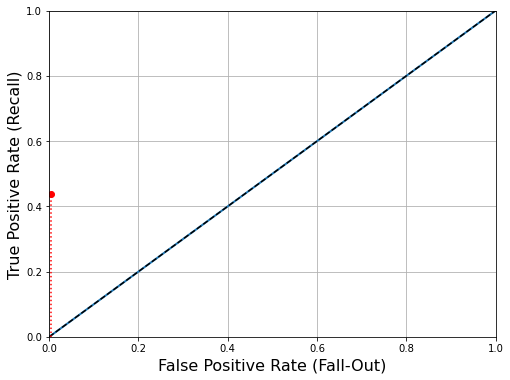

In [61]:
fpr, tpr, thresholds = roc_curve(flat_true_labels, flat_predictions)
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [62]:
roc_auc_score(flat_true_labels, flat_predictions)

0.5

Valid

In [63]:
# Get embeddings for valid
p = [group for group in embeddings_vl]

b = [item for sublist in [[list(t) for t in zip(sublist[0], sublist[1])] for sublist in p] for item in sublist]
df = pd.DataFrame(b, columns = ['id', 'embeddings'])  

bert_embeddings_df_valid = pd.concat([df['id'], df['embeddings'].apply(pd.Series)], axis = 1)
bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].apply(lambda x: x.item())
#bert_embeddings_df_valid = pd.merge(df_valid.drop(['text'], axis=1), bert_embeddings_df_valid, left_on = ["id"], right_on = ["id"])
bert_embeddings_df_valid = pd.merge(df_valid.drop(['text'], axis=1), bert_embeddings_df_valid.drop(['id'], axis=1), left_index=True, right_index=True)
print('Valid Embeddings Extraction and Merge DONE.')
bert_embeddings_df_valid.head()

Valid Embeddings Extraction and Merge DONE.


,user.id,suspended,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,1.278120e+18,1,0.010363,-0.048464,0.070922,-0.070857,0.085623,0.061585,-0.057252,0.027435,...,0.037334,0.102237,0.073004,-0.180401,-0.040452,-0.084175,0.006600,-0.143480,-0.058770,0.030264
1,1.278120e+18,1,0.010046,-0.048130,0.070977,-0.070858,0.085698,0.061547,-0.057379,0.027473,...,0.037193,0.102257,0.072940,-0.180256,-0.040605,-0.084344,0.006595,-0.143577,-0.058987,0.030342
2,1.278120e+18,1,0.010207,-0.048355,0.071010,-0.070758,0.085596,0.061632,-0.057339,0.027481,...,0.037190,0.102264,0.072914,-0.180268,-0.040389,-0.084358,0.006621,-0.143457,-0.058912,0.030277
3,1.278120e+18,1,0.010245,-0.048439,0.070807,-0.070773,0.085688,0.061460,-0.057095,0.027423,...,0.037253,0.102392,0.072897,-0.180340,-0.040403,-0.084287,0.006527,-0.143631,-0.058888,0.030331
4,1.278120e+18,1,0.010218,-0.048418,0.070966,-0.070844,0.085499,0.061487,-0.057189,0.027472,...,0.037271,0.102307,0.072969,-0.180286,-0.040419,-0.084260,0.006558,-0.143526,-0.058822,0.030307


In [64]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
# For each input batch...
for i in range(len(true_labels_valid)):
  
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions_valid[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels_valid[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning:

invalid value encountered in double_scalars



In [65]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions_valid for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels_valid for item in sublist]
# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('MCC: %.3f' % mcc)

MCC: 0.000


In [66]:
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(flat_true_labels, flat_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1805
           1       0.00      0.00      0.00       152

    accuracy                           0.92      1957
   macro avg       0.46      0.50      0.48      1957
weighted avg       0.85      0.92      0.89      1957



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



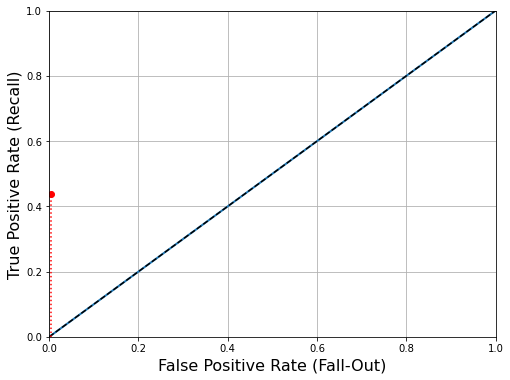

In [67]:
fpr, tpr, thresholds = roc_curve(flat_true_labels, flat_predictions)
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [68]:
roc_auc_score(flat_true_labels, flat_predictions)

0.5

### Export Models and Embeddings

In [69]:
bert_embeddings_df_train['user.id'] = bert_embeddings_df_train['user.id'].astype('str')
bert_embeddings_df_train['user.id'] = bert_embeddings_df_train['user.id'].apply(lambda x: "'" + x + "'")
bert_embeddings_df_valid['user.id'] = bert_embeddings_df_valid['user.id'].astype('str')
bert_embeddings_df_valid['user.id'] = bert_embeddings_df_valid['user.id'].apply(lambda x: "'" + x + "'")

In [70]:
print("full train:", len(bert_embeddings_df_train), "unique ids train:", len(bert_embeddings_df_train['user.id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid), "unique ids valid:", len(bert_embeddings_df_valid['user.id'].unique()))

full train: 4771 unique ids train: 1516 full valid: 1957 unique ids valid: 550


Save

In [71]:
model_to_save = model.module if hasattr(model, "module") else model # Take care of distributed/parallel training
model_to_save.save_pretrained('./Multilingual_Tweettext_mode/')
tokenizer.save_pretrained('./Multilingual_Tweettext_mode/')

('./Multilingual_Tweettext_mode/tokenizer_config.json',
 './Multilingual_Tweettext_mode/special_tokens_map.json',
 './Multilingual_Tweettext_mode/vocab.txt',
 './Multilingual_Tweettext_mode/added_tokens.json')

In [72]:
bert_embeddings_df_train.to_csv('ml_training_embeddings_df_full.csv', index=False, encoding = "utf_8_sig")
bert_embeddings_df_valid.to_csv('ml_valid_embeddings_df_full.csv', index=False, encoding = "utf_8_sig")

### Evaluate on Test

Let’s take a look at our training loss over all batches:

Now we’ll load the holdout dataset and prepare inputs just as we did with the training set. Then we’ll evaluate predictions using Matthews correlation coefficient (MCC wiki)because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.


In [73]:
# Convert to tensors.
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)
prediction_ids = torch.tensor(ids_test)

# Set the batch size.  
batch_size = 8 
# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels, prediction_ids)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [74]:
prediction_inputs.shape

torch.Size([1306, 120])

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set

In [75]:
embeddings_te = []
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask, labels=b_labels)
    logits = outputs[1]
    # Embeddings extraction approach is to average the second to last hiden layer of each token producing a single 768 length vector
    # https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
    hidden_state_te = outputs[2]
    token_vecs = hidden_state_te[-2]
    token_vecs_sentvecs = []
    for token in token_vecs:
        sentvecs = torch.mean(token, dim=0).detach().cpu().numpy()
        token_vecs_sentvecs.append(sentvecs)
    # features = hidden_state_te[12][:,0,:].detach().cpu().numpy()
    embeddings_te.append([batch[3], token_vecs_sentvecs])
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    


Predicting labels for 1,306 test sentences...


Extract Embeddings

In [76]:
# Get embeddings for test
p = [group for group in embeddings_te]

b = [item for sublist in [[list(t) for t in zip(sublist[0], sublist[1])] for sublist in p] for item in sublist]
df = pd.DataFrame(b, columns = ['id', 'embeddings'])  

bert_embeddings_df_test = pd.concat([df['id'], df['embeddings'].apply(pd.Series)], axis = 1)
bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].apply(lambda x: x.item())
#bert_embeddings_df_test = pd.merge(df_test.drop(['text'], axis=1), bert_embeddings_df_test, left_on = ["id"], right_on = ["id"])
bert_embeddings_df_test = pd.merge(df_test.drop(['text'], axis=1), bert_embeddings_df_test.drop(['id'], axis=1), left_index=True, right_index=True)
print('DONE.')
bert_embeddings_df_test.head()

DONE.


,user.id,suspended,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,1.278130e+18,0,0.009827,-0.048749,0.071129,-0.071275,0.085561,0.062034,-0.057142,0.027406,...,0.036541,0.102735,0.072812,-0.180048,-0.040371,-0.084562,0.006620,-0.143671,-0.058945,0.030478
1,1.278145e+18,1,0.009697,-0.048722,0.070796,-0.071207,0.085105,0.062381,-0.055978,0.027264,...,0.036597,0.102771,0.072694,-0.179905,-0.040769,-0.084922,0.006366,-0.143568,-0.058933,0.030678
2,1.278155e+18,0,0.010044,-0.048508,0.071139,-0.071050,0.085248,0.061772,-0.056688,0.027562,...,0.036502,0.102469,0.072623,-0.180399,-0.040627,-0.084828,0.006468,-0.143633,-0.058847,0.030356
3,1.278156e+18,0,0.009797,-0.048160,0.071499,-0.071172,0.085626,0.061782,-0.057531,0.027923,...,0.036880,0.102575,0.072678,-0.180195,-0.040778,-0.084685,0.006656,-0.144114,-0.058907,0.030613
4,1.278181e+18,0,0.009625,-0.047984,0.071321,-0.071075,0.084817,0.062047,-0.057358,0.028000,...,0.036760,0.102748,0.071478,-0.179540,-0.040540,-0.084890,0.006917,-0.143667,-0.059111,0.030738


In [77]:
bert_embeddings_df_test['user.id'] = bert_embeddings_df_test['user.id'].astype('str')
bert_embeddings_df_test['user.id'] = bert_embeddings_df_test['user.id'].apply(lambda x: "'" + x + "'")

In [78]:
print("full train:", len(bert_embeddings_df_test), "unique ids train:", len(bert_embeddings_df_test['user.id'].unique()))

full train: 1306 unique ids train: 498


Save

In [79]:
bert_embeddings_df_test.to_csv('ml_test_embeddings_df_full.csv', index=False, encoding = "utf_8_sig")

Look at imbalance. 

In [80]:
print('Positive samples: %d of %d (%.2f%%)' % (df_train.suspended.sum(), len(df_train.suspended), (df_train.suspended.sum() / len(df_train.suspended) * 100.0)))

Positive samples: 397 of 4771 (8.32%)


In [81]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
# For each input batch...
for i in range(len(true_labels)):
  
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning:

invalid value encountered in double_scalars



In [82]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('MCC: %.3f' % mcc)

MCC: 0.000


In [83]:
report = classification_report(flat_true_labels, flat_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1175
           1       0.00      0.00      0.00       131

    accuracy                           0.90      1306
   macro avg       0.45      0.50      0.47      1306
weighted avg       0.81      0.90      0.85      1306



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



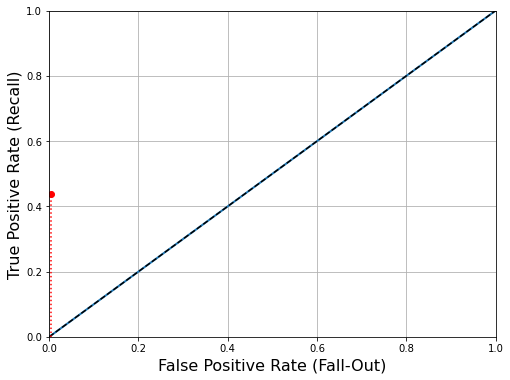

In [84]:
fpr, tpr, thresholds = roc_curve(flat_true_labels, flat_predictions)
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [85]:
roc_auc_score(flat_true_labels, flat_predictions)

0.5

### Output Predictions by Account

In [86]:
# Generate class predictions at the account level 
def predict_tweet_text(predictions, df_overlap, df_full):
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_overlap, df, left_index=True, right_index=True)
    df_fm = df_full[['user.screen_name','user.id']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_3 = pd.merge(df_fm, df_2, left_on='user.id', right_on='user.id')
    df_3 = df_3.sort_values(by=['pred'], ascending=False)
    return df_3

In [87]:
test_preds_tweets = predict_tweet_text(flat_predictions, df_test, df_test_f)
test_preds_tweets.head()

,user.screen_name,user.id,text,suspended,pred
0,MMunir50647063,1.278130e+18,@ImranKhanPTI me mazor adme ho,0,0
857,BuzzCurated,1.282178e+18,A lot of other priorities as well. Sign Roca i...,0,0
875,BuzzCurated,1.282178e+18,We hope you'll be around for long. @AFTVMedia ...,0,0
874,BuzzCurated,1.282178e+18,remember the last FA Cup final he played in? B...,0,0
873,BuzzCurated,1.282178e+18,@HuXijin_GT I can only say this to your mental...,0,0


In [88]:
test_preds_tweets.to_csv('test_preds_tweets.csv', index=False, encoding = "utf_8_sig")

In [89]:
# Generate class predictions at the account level 
def predict_account(pred_tt):
    df_4 = pred_tt[['user.screen_name', 'suspended','pred']].groupby('user.screen_name').agg(['sum', 'mean'])
    df_4.drop(('suspended', 'sum'), axis = 1, inplace = True)
    df_4.columns = [' '.join(col).strip() for col in df_4.columns.values]
    df_4.reset_index(level=0, inplace=True)
    df_4.columns = ["user.screen_name","suspended_label", "total_pre_prob","mean_pred_prob"]
    df_4['pred_class'] = np.where(df_4['mean_pred_prob'] > 0.25, 1,0) # Use lighter threshold as not all tweets get an account suspended. 
    df_4 = df_4.sort_values(by=['total_pre_prob'], ascending=False)

    return df_4

In [90]:
test_account_preds_tweettext = predict_account(test_preds_tweets)
test_account_preds_tweettext

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,2ebRkaTgSVMcGrl,0,0,0,0
327,ZiaKhan07341037,1,0,0,0
340,anwang98338943,0,0,0,0
339,anan48860464,0,0,0,0
338,aksuizen,0,0,0,0
...,...,...,...,...,...
161,Khansial12,0,0,0,0
160,KhanSha42957509,0,0,0,0
159,KhanKha27106664,0,0,0,0
158,Khairul96801635,0,0,0,0


### Confusion Matrix for Account Classification

In [91]:
#report = classification_report(np.array(test_labels), predictions)
report_te = classification_report(np.array(test_account_preds_tweettext['suspended_label']), np.array(test_account_preds_tweettext['pred_class']))
print(report_te)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       460
           1       0.00      0.00      0.00        38

    accuracy                           0.92       498
   macro avg       0.46      0.50      0.48       498
weighted avg       0.85      0.92      0.89       498



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



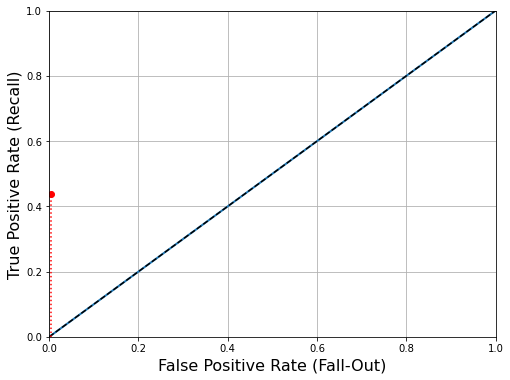

In [92]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_tweettext['suspended_label']), np.array(test_account_preds_tweettext['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [93]:
roc_auc_score(np.array(test_account_preds_tweettext['suspended_label']), np.array(test_account_preds_tweettext['pred_class']))

0.5

In [94]:
test_account_preds_tweettext.to_csv('test_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")